# Summary

This notebook provides a breath of all the features offered in the project. 

# Imports/Setup

In [1]:
from Data import dataset, generator
from Data import utility as data_utility
from Evaluation import utility as eval_utility
from Model import actors, scipy
from Model import utility as model_utility
from Objectives import losses
import matplotlib.pyplot as plt

/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred whil

This configuration class is the central control for the training process.

In [2]:
class Config:
    # dataset
    batch_size = 32
    gen_size = 5
    mat_size = 5**2
    seed = 42
    
    # dataloader
    train_len = 1000
    valid_len = 100
    shuffle = True
    
    # device
    device_pref = 'cuda'
    device_ind = 3
    
    # model
    hidden = 256 # 128 for LU (it doubles the amount of layers) | 512 for NID it has larger output same layers | 256 else
    sparse_tol = 1e-5
    diagonal_bias = 0.1
    
    # loss
    l1 =  0
    inv = 0
    dev = 0
    cond = 1.0
    
    # training
    epoches = 100
    lr = 1e-5
    verbose = False
    file_path = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/testing_3.pth'
    
    # model save/load
    file_path = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/testing_3.pth'
    
    # train save/load
    log_path = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/logs_2.npz'

# Dataset/Dataloader

There are two different provided test cases, one SPD and the other NID.

In [3]:
train_dataset_params = {
    'generator': generator.generate_2d_diffusion_spd,
    'norm_feat': data_utility.normalize_features,
    'epoch_len': Config.train_len,
    'batch_size': Config.batch_size,
    'size': Config.gen_size
}

valid_dataset_params = {
    'generator': generator.generate_2d_diffusion_spd,
    'norm_feat': data_utility.normalize_features,
    'epoch_len': Config.valid_len,
    'batch_size': Config.batch_size,
    'size': Config.gen_size
}

In [4]:
train_dataset = dataset.SystemDataset(**train_dataset_params)
valid_dataset = dataset.SystemDataset(**valid_dataset_params)

In [5]:
train_dataloader_params = {
    'dataset': train_dataset,
    'batch_size': Config.batch_size,
    'shuffle': Config.shuffle
}

valid_dataloader_params = {
    'dataset': valid_dataset,
    'batch_size': Config.batch_size,
    'shuffle': Config.shuffle
}

In [6]:
train_dataloader = dataset.get_dataloader(**train_dataloader_params)
valid_dataloader = dataset.get_dataloader(**valid_dataloader_params)

In [7]:
A, b = next(iter(train_dataloader))

Determinent: 959762944.0
Matrix is non-singular.
Condition: 4253.85546875
SPD


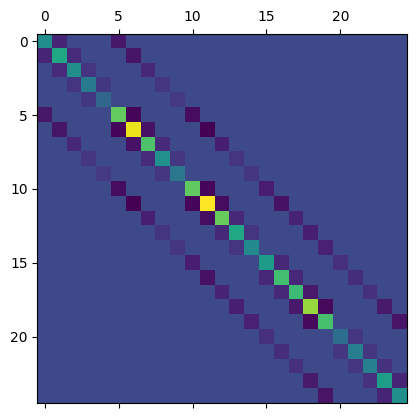

In [8]:
ind = 0
fig, ax = plt.subplots(1, 1)

data_utility.check_singularity(A, ind)
data_utility.check_conditioning(A, ind)
data_utility.view_matrix(A, ind, ax)
print('SPD') if data_utility.is_spd(A, ind) else print('Non-SPD')

# Device

Gather the device.

In [9]:
device_params = {
    'device_pref': Config.device_pref,
    'ind_dev': Config.device_ind
}

In [10]:
device = data_utility.set_device(**device_params)

Now using GPU.


# Model

The primary driver is a linear model. Our setup allows for easy swappout as long as the model ouputs a batch of preconditioners.

In [11]:
model_params = {
    'n':Config.mat_size,
    'hidden':Config.hidden,
    'batch_size':Config.batch_size,
    'sparse_tol':Config.sparse_tol,
    'diagonal_bias':Config.diagonal_bias
}

In [12]:
model = actors.CholeskyFCN(**model_params).to(device)

# Loss Function

We use loss function that combines many different objective functions. This can easy be swapped out for faster and most stable training but we use this primarily for use in the hyperparameter tuning phase.

In [13]:
loss_params = {
    'l1': Config.l1,
    'inv': Config.inv,
    'dev': Config.dev,
    'cond': Config.cond,
    'batch_size': Config.batch_size,
    'size': Config.mat_size
}

In [14]:
criterion = losses.CondEyeDistance(**loss_params)

# Training

The training block. We also gather training results.

In [15]:
def step(batch, model, criterion, device, size, batch_size):
    A, b = batch
    A, b = A.to(device), b.to(device)
    output = model(A.view(batch_size, size*size))
    return criterion(A, output.view(batch_size, size, size))

training_params = {
    'epoches': Config.epoches,
    'criterion': criterion,
    'step': step,
    'train_loader': train_dataloader,
    'valid_loader': valid_dataloader,
    'model': model,
    'lr': Config.lr,
    'size': Config.mat_size,
    'batch_size': Config.batch_size,
    'device': device,
    'verbose': Config.verbose,
    'file_path': Config.file_path
}

In [59]:
train_log, valid_log = model_utility.shared_training_loop(**training_params)

Epoch: 0, Train: 1.2638426232337951, Valid: 1.2598508167266846
Epoch: 1, Train: 1.2516646062135697, Valid: 1.2795119655132294
Epoch: 2, Train: 1.2446021109819412, Valid: 1.2535628914833068
Epoch: 3, Train: 1.2402566826343537, Valid: 1.4962711572647094
Epoch: 4, Train: 1.2371451888084413, Valid: 1.2401217496395112
Epoch: 5, Train: 1.2261495430469513, Valid: 1.2041577553749085
Epoch: 6, Train: 1.220173397898674, Valid: 1.1996471035480498
Epoch: 7, Train: 1.2252104022502899, Valid: 1.3067807793617248
Epoch: 8, Train: 1.2145328565835953, Valid: 1.1949897110462189
Epoch: 9, Train: 1.2070407418012619, Valid: 1.1848846423625945
Epoch: 10, Train: 1.2000970541238785, Valid: 1.1755212700366975
Epoch: 11, Train: 1.227777515888214, Valid: 1.1707253777980804
Epoch: 12, Train: 1.1929822001457215, Valid: 1.2359226405620576
Epoch: 13, Train: 1.198656995177269, Valid: 1.1976814222335816
Epoch: 14, Train: 1.2053639365434647, Valid: 1.4008554935455322
Epoch: 15, Train: 1.19268101477623, Valid: 1.25012863

# Evaluation

We provide many quantitative and qualitative outlets to assess training strength.

In [60]:
plot_training_params = {
    'train_log': train_log,
    'valid_log': valid_log,
    'title': 'EX', 
    'file_path': 'plt.png'
}

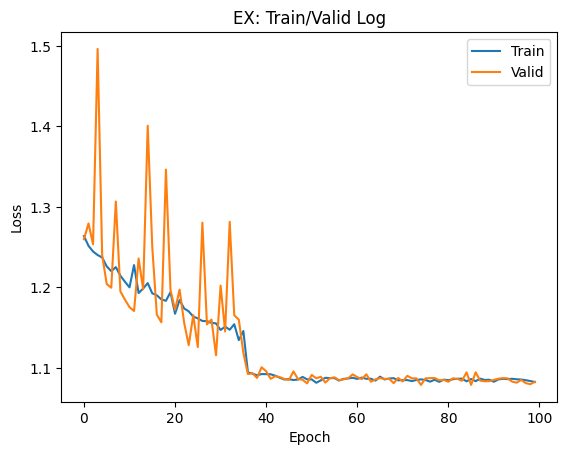

In [61]:
eval_utility.plot_training(**plot_training_params)

In [62]:
eval_instance_params = {
    'A': next(iter(valid_dataloader))[0],
    'model': model,
    'ind': 0,
    'size': Config.mat_size,
    'batch_size': Config.batch_size,
    'device': device,
    'criterion': criterion,
    'file_path': 'ex_3.png'
}

Loss: 1.1413531303405762
Inner DET: 0.18362554907798767
Output min: 10.271187782287598


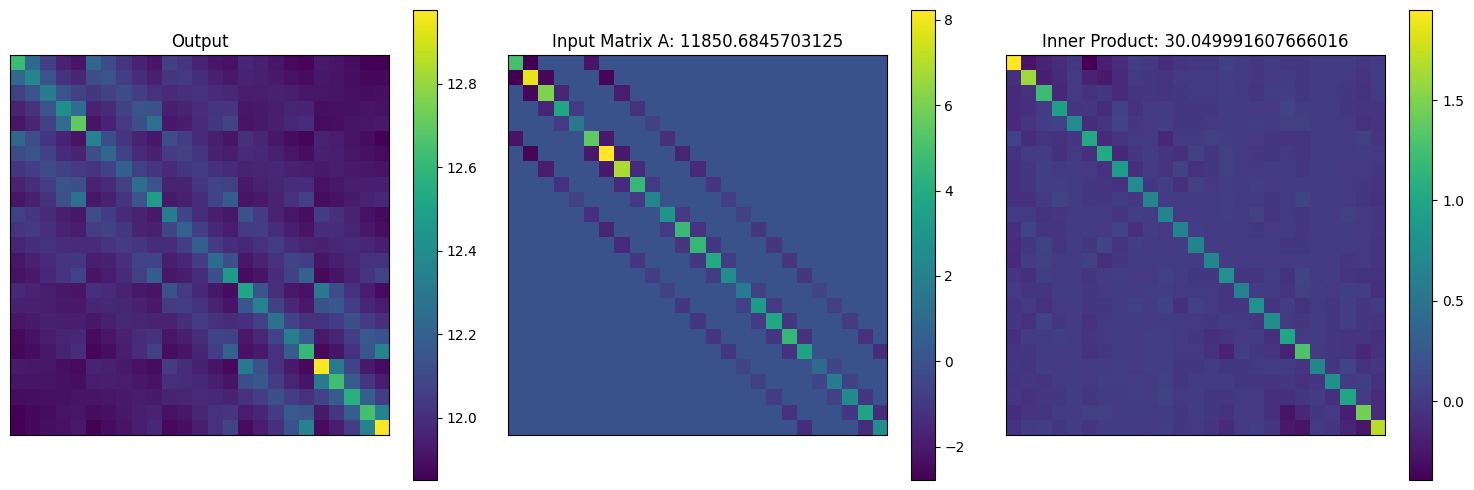

In [63]:
eval_utility.inspect_instance(**eval_instance_params)

In [77]:
import torch
from scipy.sparse.linalg import LinearOperator, cg, gmres
import numpy as np

As = next(iter(valid_dataloader))[0].view(32, 25*25).to(device)

model.eval()
with torch.no_grad():
    out = model(As)[0]
    
A, b = As[0].view(25, 25).cpu().numpy(), torch.randn(25).numpy()
P = out.cpu().numpy()

# cg for guranteed SPD, gmres else

x, info = cg(A, b, M=P, rtol=1e-8, maxiter=25)
pnorm = np.linalg.norm(A @ x - b)
print('Preconditioned', pnorm, info)

x, info = cg(A, b, rtol=1e-8, maxiter=25)
bnorm = np.linalg.norm(A @ x - b)
print('Base', bnorm, info)

print('Preconditioned wins!' if pnorm < bnorm else 'Base Wins!')

Preconditioned 0.00021649274 0
Base 0.0026097847 25
Preconditioned wins!


# Model Save/Load

Our built in saving functions. They use the standard torch api.

In [21]:
model_utility.save_model(model, Config.file_path)

In [22]:
model_utility.load_model(model, Config.file_path)

/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/Model/utility.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(sta

# Training Logs Save/Load

Built in saving/loading functions for training statistics. We use the standard numpy api.

In [23]:
eval_utility.save_logs(train_log, valid_log, Config.log_path)

Logs saved to: /data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/logs.npz


In [24]:
train_log, valid_log = eval_utility.read_logs(Config.log_path)

Logs read from: /data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/logs.npz


# Traditional Preconditioners

An optional section that can be utilized to view the output of traditional preconditioning techniques.

In [9]:
import numpy as np

In [10]:
data = next(iter(valid_dataloader))[0].numpy()
ind = 0

In [11]:
trad_precond_params = {
    'batch_matrix': data, 
    'ind': ind, 
    'fill_factor': 1, 
    'max_levels': 1, 
    'strength': 'classical'
}

The preconditioners converge on the block diagonal but is there any other patterning. It also looks like these have a strong main diagonal but the learned representation from the model has a weak diagonal.

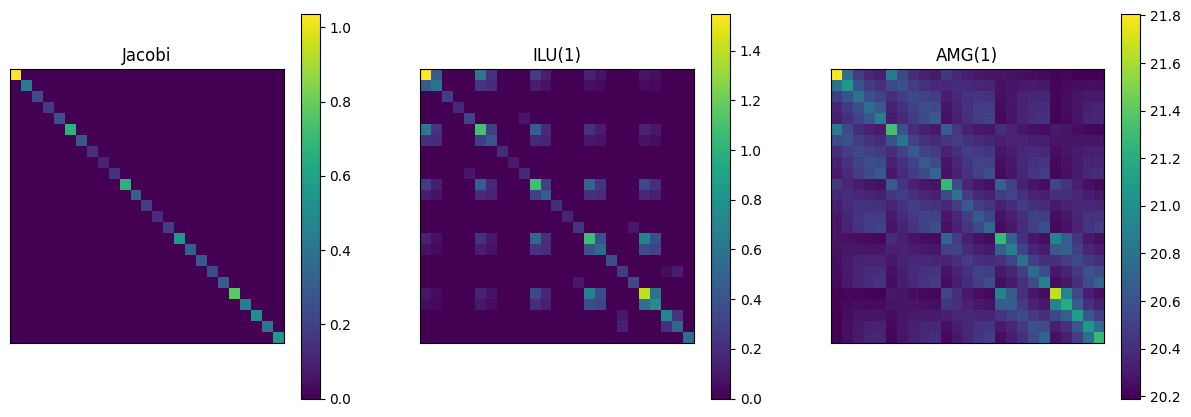

In [13]:
jac, ilu, amg = scipy.get_traditional_preconditioners(**trad_precond_params)

In [19]:
scipy.check_conditioning(data, np.eye(25), 0)
scipy.check_conditioning(data, jac, 0)
scipy.check_conditioning(data, ilu, 0) 
scipy.check_conditioning(data, amg, 0)
(10640.796906837086 / 12947.11173626841) * 25

Condition: 12747.302244633209
Condition: 12947.11173626841
Condition: 10640.796906837086
Condition: 25.0


20.54666153268241

# Torch Conjugate Gradient

Using library to do batched conjugate gradient for conjugate gradient.

In [65]:
from torch_cg.torch_cg import cg_batch

In [66]:
A, b = next(iter(valid_dataloader)) 
A = A.to(device)
out = model(A.view(Config.batch_size, Config.mat_size * Config.mat_size)).view(Config.batch_size, Config.mat_size, Config.mat_size)
A, out = A.cpu(), out.detach().cpu()

In [67]:
b = torch.randn(32, 25, 1)

xs = cg_batch(lambda x: torch.matmul(A, x), b, lambda x: torch.matmul(out, x), maxiter=25, verbose=True)

 it |       dist   it/s
001 | 1.6902e+00 184.25
002 | 6.4992e-01 1899.03
003 | 1.7067e-01 1118.77
004 | 5.8453e-02 2564.67
005 | 1.2798e-02 2453.54
006 | 5.2227e-04 2591.05
007 | -2.7950e-03 2651.95
Terminated in 7 steps (reached maxiter). Took 9.733 ms.
